# Libreries

In [1]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from itertools import product
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definitions

In [3]:
pwd

'/content'

In [4]:

train_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/clustering/VGG16_agglomerative_v0/train"

validation_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/clustering/VGG16_agglomerative_v0/validation"
'''
train_path ="/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/Dataset-rama-aug/train"
validation_path ="/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/Dataset-rama-aug/validation"
'''
test_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/test"

encoder_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Results/Autoencoder/encoder_SSIM_MAE_Bparams.keras"

save_path="/content/drive/My Drive/Investigacion/UTN/GIAR/Results/Supervised_results"



In [5]:
SHAPE = (128,128,1)
batch_size = 32
TRAIN_ENCODER = False
COLOR_MODE="grayscale"

# Confusion matrix

In [6]:

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [7]:
results = []
def plot_conf_matrix(model, generator, titulo='Confusion matrix'):
    ### RETRIVE TEST LABEL FROM GENERATOR ###
    test_num = sum(1 for _ in generator)
    label_test = []
    pred_test = []

    for i, batch in enumerate(generator):
        X, y = batch
        label_test.append(y.numpy())
        predictions = model.predict(X)
        predictions = tf.nn.softmax(predictions, axis=-1)
        pred_test.append(predictions)


    label_test = np.argmax(np.vstack(label_test), axis=1)


    ### COMPUTE PREDICTIONS ON TEST DATA ###
    pred_test = np.argmax(np.vstack(pred_test), axis=1)
    accuracy=accuracy_score(label_test, pred_test)
    recall=recall_score(label_test, pred_test,pos_label=0)
    specificity=recall_score(label_test, pred_test,pos_label=1)
    precision = precision_score(label_test, pred_test, pos_label=0)
    # pred_test = pred_test[:label_test.shape[0],]
    ### ACCURACY ON TEST DATA ###
    print("-" * 40)
    print('ACCURACY:', accuracy)
    print('RECALL:',recall)
    print('PRECISION:', precision)
    print('SPECIFICITY:',specificity)
    print("-" * 40)
    print("\n")
    ### CONFUSION MATRIX ON TEST DATA ###
    cnf_matrix = confusion_matrix(label_test, pred_test)
    results.append({'Model': titulo, 'Accuracy': accuracy , 'Recall':recall,'Precision':precision,'Specificity':specificity})

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=['cell', 'not'], title=titulo)
    plt.title(titulo)
    plt.show()


# Datasets

In [8]:
# data generator function
def data_gen ():
    train_generator = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    train_generator = train_generator.map(
        lambda x, y: (x/255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    validation_generator = tf.keras.utils.image_dataset_from_directory(
        validation_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    validation_generator = validation_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)



    test_generator = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    test_generator = test_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_generator = test_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_generator,validation_generator,test_generator


Found 14000 files belonging to 2 classes.
(32, 128, 128, 1)
(32, 2)


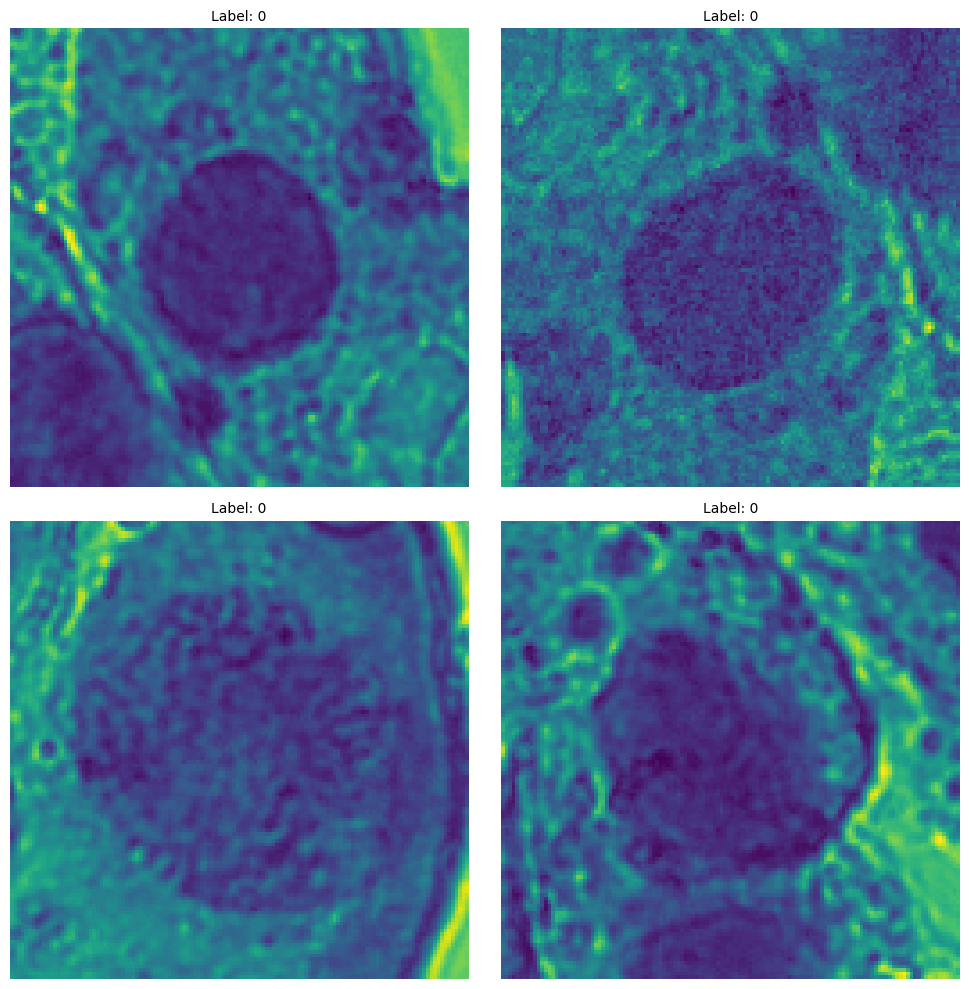

In [9]:
# plot images
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(SHAPE[0], SHAPE[1]),
    color_mode=COLOR_MODE,
    shuffle=False,
)



for images, labels in train_generator:
    print(images.shape)
    print(labels.shape)

    #filenames_in_batch = [train_generator.filenames[idx] for idx in train_generator.index_array]

    plt.figure(figsize=(10, 10))

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))

        #file_name = filenames_in_batch[i]
        label = np.argmax(labels[i])
        plt.title(f"Label: {label}", fontsize=10)

        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [10]:
train_generator.class_names

['cells', 'not']

# Model

In [11]:

def get_model(pretrain_encoder,TRAIN_ENCODER,input_shape,dropout_rate, l2_reg):
    encoder=pretrain_encoder

    inp = keras.Input(shape=input_shape)
    x = inp

    encoder.trainable = TRAIN_ENCODER

    x = encoder(x)

    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out =layers.Dense(2, activation='linear')(x)


    model = keras.Model(inp, out)

    return model


# Train

Found 14000 files belonging to 2 classes.
Found 6693 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.5537 - loss: 0.7851 - val_accuracy: 0.6998 - val_loss: 0.6669
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 66s 152ms/step - accuracy: 0.6212 - loss: 0.6875 - val_accuracy: 0.7364 - val_loss: 0.6122
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6694 - loss: 0.6504 - val_accuracy: 0.7515 - val_loss: 0.5572
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.6894 - loss: 0.6227 - val_accuracy: 0.7526 - val_loss: 0.5479
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6899 - loss: 0.6171 - val_accuracy: 0.7508 - val_loss: 0.5466
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7007 - loss: 0.6047 - val_accuracy: 0.7553 - val_loss: 0.5450
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7060 - loss: 0.6004 - val_a

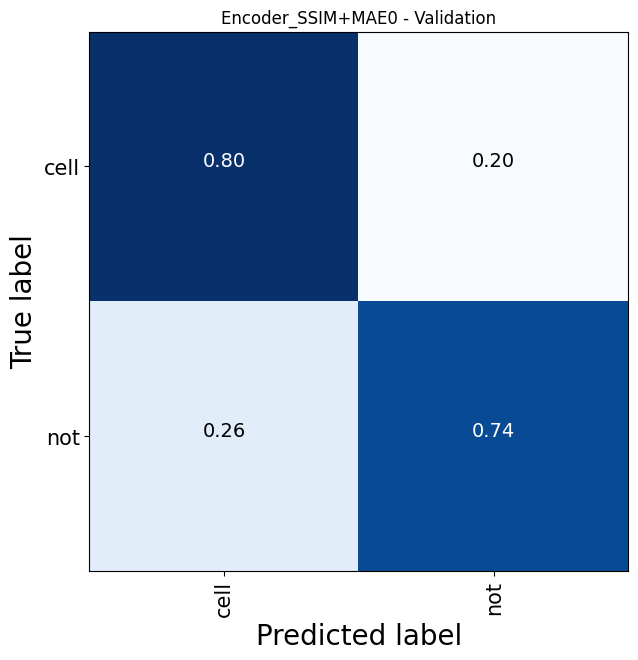

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

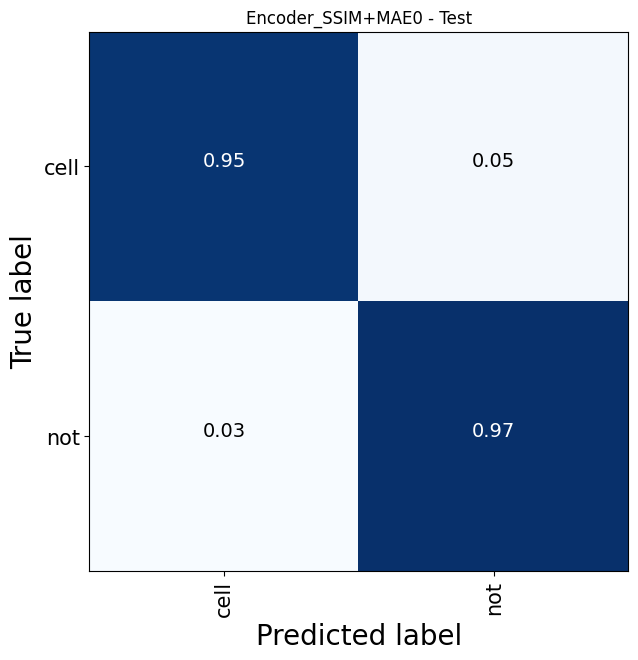

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.5530 - loss: 1.0688 - val_accuracy: 0.6759 - val_loss: 0.8590
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.6336 - loss: 0.8411 - val_accuracy: 0.7218 - val_loss: 0.6878
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6703 - loss: 0.7194 - val_accuracy: 0.7469 - val_loss: 0.6173
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6939 - loss: 0.6577 - val_accuracy: 0.7512 - val_loss: 0.5784
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6982 - loss: 0.6219 - val_accuracy: 0.7539 - val_loss: 0.5571
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7015 - loss: 0.6085 - val_accuracy: 0.7624 - val_loss: 0.5477
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.7062 - loss: 0.5986 - val_accuracy: 0.7554 - val_loss: 0.5436
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7074 - loss: 0.5911 - 

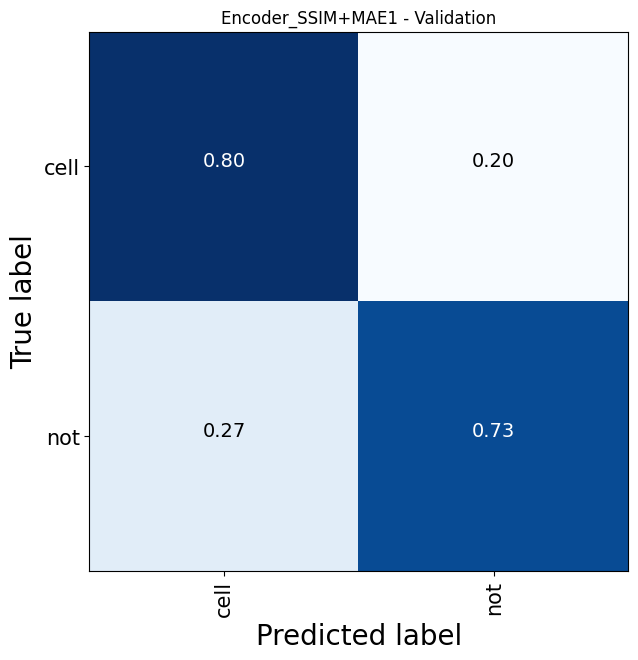

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

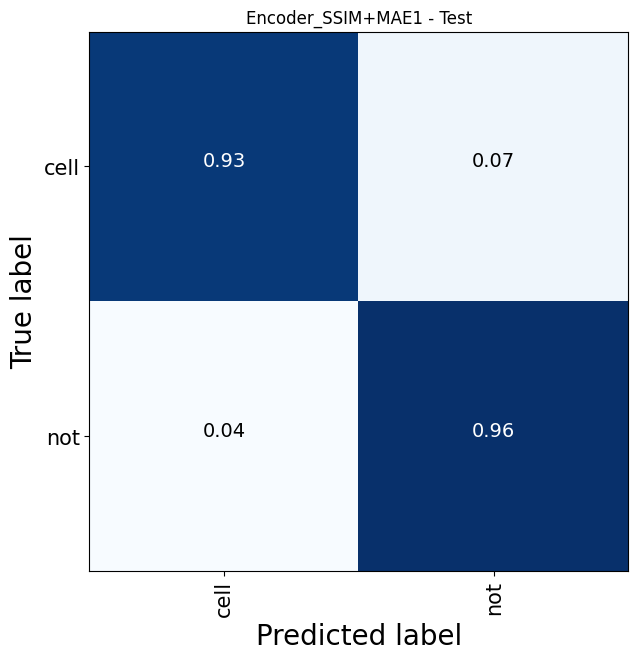

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.5199 - loss: 0.8654 - val_accuracy: 0.5270 - val_loss: 0.7341
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5303 - loss: 0.7331 - val_accuracy: 0.5697 - val_loss: 0.7226
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5415 - loss: 0.7200 - val_accuracy: 0.6655 - val_loss: 0.6970
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.5888 - loss: 0.6974 - val_accuracy: 0.7184 - val_loss: 0.6366
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6294 - loss: 0.6707 - val_accuracy: 0.7260 - val_loss: 0.6106
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6434 - loss: 0.6602 - val_accuracy: 0.7348 - val_loss: 0.5936
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6563 - loss: 0.6496 - val_accuracy: 0.7375 - val_loss: 0.5836
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6693 - loss: 0.6402 - 

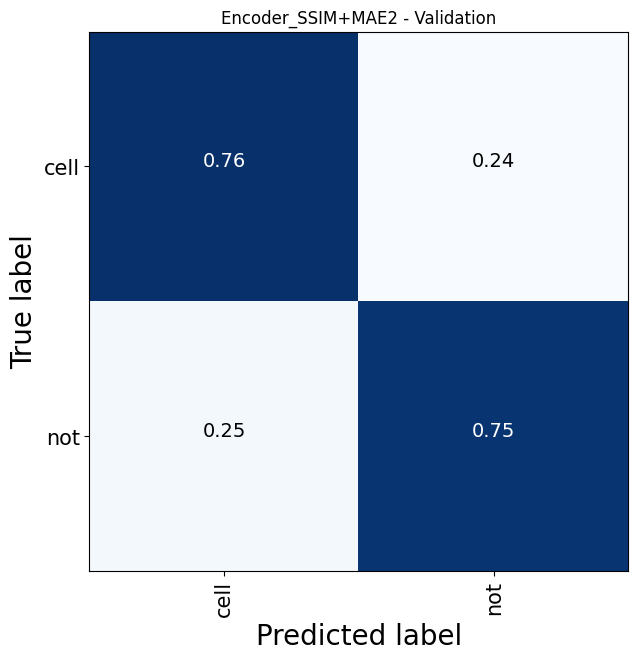

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

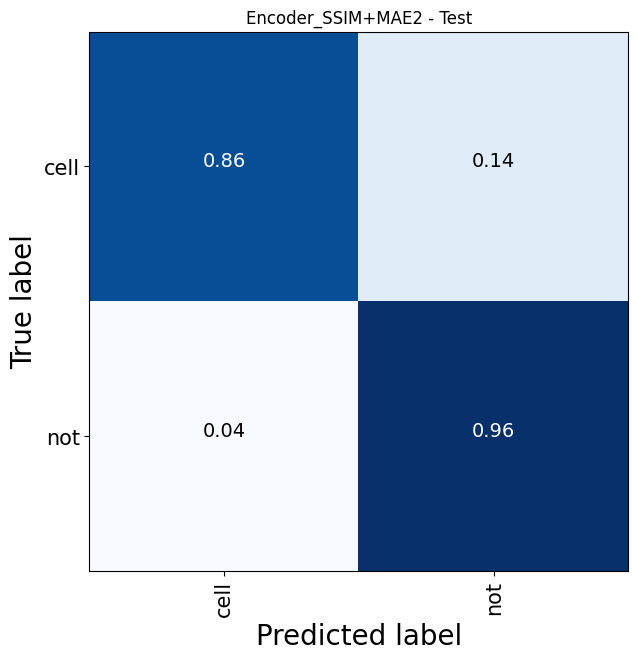

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.5200 - loss: 1.0924 - val_accuracy: 0.6967 - val_loss: 0.8669
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5535 - loss: 0.8511 - val_accuracy: 0.6980 - val_loss: 0.7236
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6294 - loss: 0.7326 - val_accuracy: 0.7329 - val_loss: 0.6271
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.6556 - loss: 0.6707 - val_accuracy: 0.7402 - val_loss: 0.5834
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6676 - loss: 0.6431 - val_accuracy: 0.7379 - val_loss: 0.5740
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.6775 - loss: 0.6303 - val_accuracy: 0.7487 - val_loss: 0.5598
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6740 - loss: 0.6264 - val_accuracy: 0.7426 - val_loss: 0.5580
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.6831 - loss: 0.6183 - 

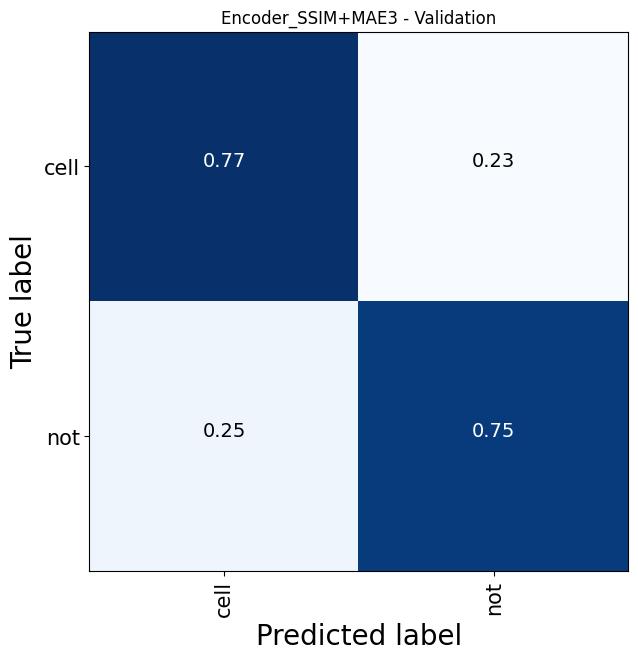

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

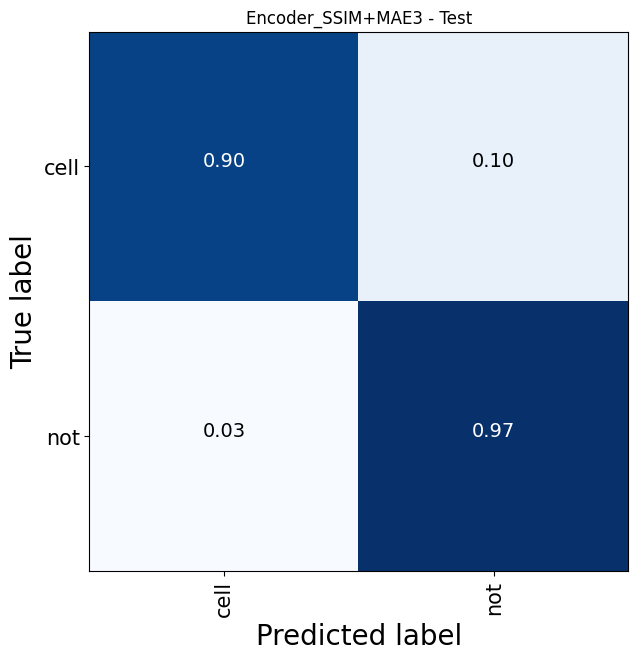

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.6202 - loss: 0.6438 - val_accuracy: 0.7487 - val_loss: 0.5392
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.7507 - loss: 0.5170 - val_accuracy: 0.7624 - val_loss: 0.5080
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.7555 - loss: 0.5143 - val_accuracy: 0.7710 - val_loss: 0.4944
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.7558 - loss: 0.5092 - val_accuracy: 0.7719 - val_loss: 0.4885
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.7581 - loss: 0.5026 - val_accuracy: 0.7751 - val_loss: 0.4896
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.7595 - loss: 0.5068 - val_accuracy: 0.7741 - val_loss: 0.4897
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.7543 - loss: 0.5096 - val_accuracy: 0.7742 - val_loss: 0.4877
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.7618 - loss: 0.5029 - 

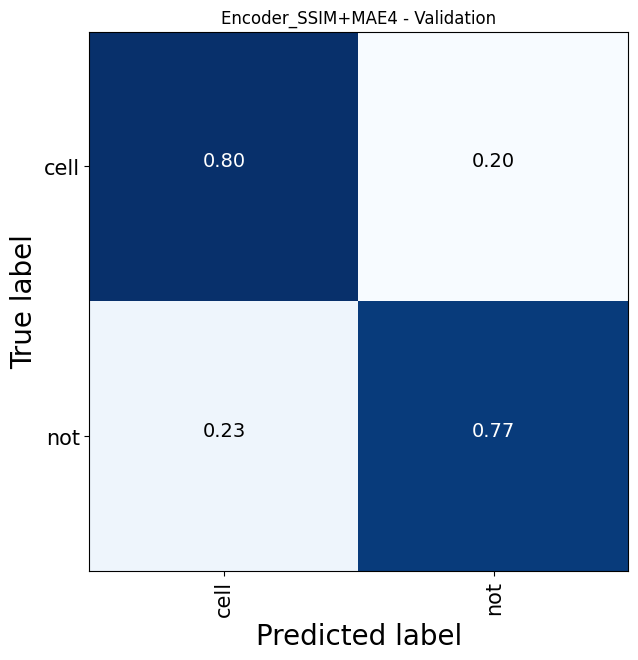

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

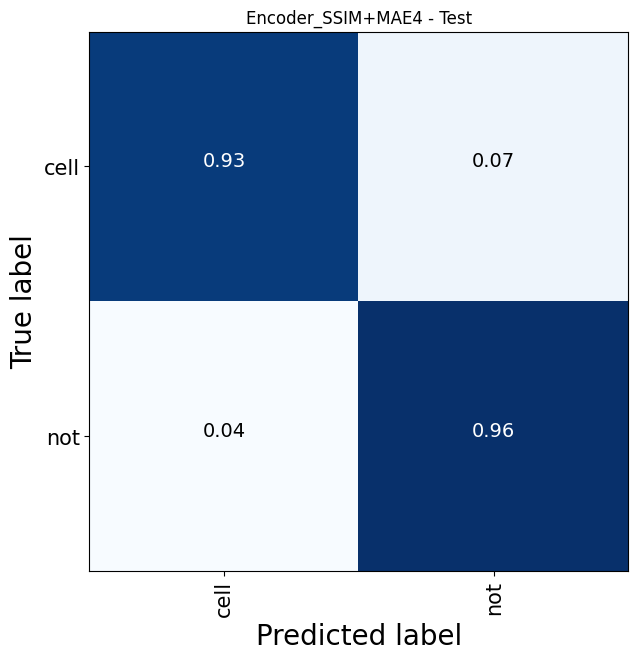

In [12]:
train_generator,validation_generator,test_generator=data_gen()
stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2,
)

param_grid = {
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [1e-3, 0.01],
}
combinations = list(product(*param_grid.values()))
combinations.append((0.0, 0.0))

for i, params in enumerate(combinations):

  encoder_name="Encoder_SSIM+MAE"+str(i)
  encoder= keras.saving.load_model(encoder_path)
  model = get_model(encoder,TRAIN_ENCODER,SHAPE,params[0],params[1])
  model.compile(keras.optimizers.Adam(
    #  1e-4
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
      )


  model.fit(train_generator,
          epochs=50,
          validation_data = validation_generator,
          callbacks=[ stopping],
          )
  model.save(save_path+f'/model_{encoder_name}.keras')
  print()
  print(params)
  print()
  plot_conf_matrix(model, validation_generator, f'{encoder_name} - Validation')
  plot_conf_matrix(model, test_generator, f'{encoder_name} - Test')



In [13]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df.to_excel(save_path+"/resultados_Encoder_SSIM+MAE.xlsx")

print(results_df)


                            Model  Accuracy    Recall  Precision  Specificity
0  Encoder_SSIM+MAE0 - Validation  0.768265  0.802380   0.735784     0.737143
1        Encoder_SSIM+MAE0 - Test  0.957500  0.947000   0.967314     0.968000
2  Encoder_SSIM+MAE1 - Validation  0.764530  0.798309   0.732261     0.733714
3        Encoder_SSIM+MAE1 - Test  0.946500  0.929000   0.962694     0.964000
4  Encoder_SSIM+MAE2 - Validation  0.751681  0.757908   0.731339     0.746000
5        Encoder_SSIM+MAE2 - Test  0.909000  0.856000   0.957494     0.962000
6  Encoder_SSIM+MAE3 - Validation  0.760496  0.772941   0.737597     0.749143
7        Encoder_SSIM+MAE3 - Test  0.934000  0.900000   0.965665     0.968000
8  Encoder_SSIM+MAE4 - Validation  0.781712  0.795803   0.758507     0.768857
9        Encoder_SSIM+MAE4 - Test  0.945000  0.925000   0.963542     0.965000
